# Задача

Реализуем pipeline с использование текстовых признаков catboost.

# Импорты


In [46]:
import re
from string import punctuation
from copy import deepcopy

import pandas as pd
import numpy as np
import nltk
from nltk.stem.snowball import RussianStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
%matplotlib inline

from module.prepare_data import load_dataset, Preprocessor

In [2]:
RANDOM_SEED = 35

pd.set_option('display.max_colwidth', 100)

# Данные

In [3]:
test_path = '../data/test.csv'
train_path = '../data/short_train.csv'

In [4]:
df = load_dataset(train_path)
test_df = load_dataset(test_path)

# Обучение

In [21]:
def get_cb_pipeline(catboost_args):
    return Pipeline([
        ('preproc', Preprocessor('text')),
        ('clf', CatBoostClassifier(**catboost_args))
    ])

In [22]:
TEXT_PROCESSING = {
    "tokenizers": [{
        "tokenizer_id": "Space",
        "separator_type": 'ByDelimiter',
        "delimiter": " ",
        "lowercasing": "true",
        "sub_tokens_policy": 'SingleToken',
    },{
        "tokenizer_id": "Sense",
        "separator_type": 'BySense',
        "lowercasing": "true",
        "sub_tokens_policy": 'SingleToken',
    }],
    "dictionaries": [{
            "dictionary_id": "Word",
            "gram_order": "1",
            "max_dictionary_size": "50000",
            "occurrence_lower_bound": "3",
        }, {
            "dictionary_id": "BiGram",
            "gram_order": "2",
            "max_dictionary_size": "50000",
            "occurrence_lower_bound": "3",
        }, {
            "dictionary_id": "TriGram",
            "gram_order": "3",
            "max_dictionary_size": "50000",
            "occurrence_lower_bound": "3",
        }, {
            "dictionary_id": "Symbols_1",
            "token_level_type": "Letter",
            "gram_order": "1",
            "max_dictionary_size": "500",
            "occurrence_lower_bound": "1",
        }, {
            "dictionary_id": "Symbols_2",
            "token_level_type": "Letter",
            "gram_order": "2",
            "max_dictionary_size": "2500",
            "occurrence_lower_bound": "2",
        }, {
            "dictionary_id": "Symbols_3",
            "token_level_type": "Letter",
            "gram_order": "3",
            "max_dictionary_size": "10000",
            "occurrence_lower_bound": "10",
        }],
    "feature_processing": {
        "default": [{
                "dictionaries_names": [
                    "Symbols_1",
                    "Symbols_2",
                    "Symbols_3",
                    'Word',
                    "BiGram",
                    "TriGram",
                ],
                "feature_calcers": ["BoW"],
                "tokenizers_names": ["Space"]
            }, {
                "dictionaries_names": ["Symbols_1", 'Word'],
                "feature_calcers": ["NaiveBayes"],
                "tokenizers_names": ["Space"]
        }],
    }
}

In [23]:
cb_params = {
    'text_features': ['text'],
    'text_processing': TEXT_PROCESSING,
    'iterations': 100,
}

In [24]:
cb_pipeline = get_cb_pipeline(cb_params)

In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [26]:
cv_scores = cross_val_score(
    cb_pipeline,
    df[['text']],
    df['label'],
    cv=cv,
    n_jobs=5,
    scoring='roc_auc',
    verbose=1,
#     fit_params={'verbose': False}
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.0s remaining:   45.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   30.1s finished


In [27]:
cv_scores

array([0.87646471, 0.88053434, 0.88381659, 0.8826038 , 0.88625179])

О, стало заметно лучше. Бейзлайна.

## А если без пропроцессинга?

In [61]:
text_processing = deepcopy(TEXT_PROCESSING)

In [49]:
text_processing["feature_processing"] = {
    "default": [{
            "dictionaries_names": [
                "Symbols_1",
                "Symbols_2",
                "Symbols_3",
                'Word',
                "BiGram",
                "TriGram",
            ],
            "feature_calcers": ["BoW"],
            "tokenizers_names": ["Sense"]
        }, {
            "dictionaries_names": ["Symbols_1", 'Word'],
            "feature_calcers": ["NaiveBayes"],
            "tokenizers_names": ["Sense"]
    }],
}

In [50]:
cb_params = {
    'text_features': ['text'],
    'text_processing': text_processing,
    'iterations': 100,
}

In [51]:
cb_pipeline = CatBoostClassifier(**cb_params)

In [52]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [53]:
cv_scores = cross_val_score(
    cb_pipeline,
    df[['text']],
    df['label'],
    cv=cv,
    n_jobs=5,
    scoring='roc_auc',
    verbose=1,
#     fit_params={'verbose': False}
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.5s remaining:   42.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   28.8s finished


In [54]:
cv_scores

array([0.8657, 0.8589, 0.8645, 0.86  , 0.8652])

Ага, так получается хуже.

## А если получше обработку сделать?

In [70]:
text_processing = deepcopy(TEXT_PROCESSING)

In [83]:
text_processing["feature_processing"] = {
    "default": [{
            "dictionaries_names": [
                "Symbols_1",
                "Symbols_2",
                "Symbols_3",
                'Word',
                "BiGram",
                "TriGram",
            ],
            "feature_calcers": ["BoW"],
            "tokenizers_names": ["Space"]
        }, {
            "dictionaries_names": ["Symbols_1", 'Word'],
            "feature_calcers": ["NaiveBayes", 'BM25'],
            "tokenizers_names": ["Space"]
    }],
}

In [84]:
cb_params = {
    'text_features': ['text'],
    'text_processing': text_processing,
    'iterations': 100,
}

In [85]:
cb_pipeline = get_cb_pipeline(cb_params)

In [86]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [87]:
cv_scores = cross_val_score(
    cb_pipeline,
    df[['text']],
    df['label'],
    cv=cv,
    n_jobs=5,
    scoring='roc_auc',
    verbose=1,
#     fit_params={'verbose': False}
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   30.9s remaining:   46.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   31.0s finished


In [88]:
cv_scores

array([0.878 , 0.8851, 0.8852, 0.8832, 0.8893])

Лучше не стало, всё так же.

## А если деревьев больше брать?

In [89]:
cb_params = {
    'text_features': ['text'],
    'text_processing': TEXT_PROCESSING,
    'iterations': 1000,
}

In [90]:
cb_pipeline = get_cb_pipeline(cb_params)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [91]:
cv_scores = cross_val_score(
    cb_pipeline,
    df[['text']],
    df['label'],
    cv=cv,
    n_jobs=5,
    scoring='roc_auc',
    verbose=1,
#     fit_params={'verbose': False}
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.2min finished


In [92]:
cv_scores

array([0.8769, 0.8851, 0.8871, 0.884 , 0.8896])

Забавно, это не слишком помогает.

## Проверка на отложенном датасете

In [55]:
cb_params = {
    'text_features': ['text'],
    'text_processing': TEXT_PROCESSING,
    'iterations': 100,
}

In [56]:
cb_pipeline = get_cb_pipeline(cb_params)

In [57]:
cb_pipeline.fit(df[['text']], df['label'])

Learning rate set to 0.238417
0:	learn: 0.6254532	total: 60.6ms	remaining: 6s
1:	learn: 0.5779319	total: 121ms	remaining: 5.95s
2:	learn: 0.5498677	total: 181ms	remaining: 5.87s
3:	learn: 0.5290903	total: 237ms	remaining: 5.68s
4:	learn: 0.5153863	total: 294ms	remaining: 5.58s
5:	learn: 0.5057627	total: 352ms	remaining: 5.51s
6:	learn: 0.4990193	total: 410ms	remaining: 5.45s
7:	learn: 0.4936615	total: 468ms	remaining: 5.38s
8:	learn: 0.4875760	total: 524ms	remaining: 5.3s
9:	learn: 0.4840218	total: 583ms	remaining: 5.24s
10:	learn: 0.4810028	total: 642ms	remaining: 5.2s
11:	learn: 0.4785382	total: 697ms	remaining: 5.11s
12:	learn: 0.4765381	total: 751ms	remaining: 5.02s
13:	learn: 0.4754219	total: 804ms	remaining: 4.94s
14:	learn: 0.4744015	total: 860ms	remaining: 4.88s
15:	learn: 0.4727948	total: 920ms	remaining: 4.83s
16:	learn: 0.4704045	total: 980ms	remaining: 4.79s
17:	learn: 0.4693729	total: 1.03s	remaining: 4.71s
18:	learn: 0.4675882	total: 1.09s	remaining: 4.66s
19:	learn: 0.46

Pipeline(steps=[('preproc',
                 <module.prepare_data.Preprocessor object at 0x7fcc70ebeda0>),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7fcc70ebee48>)])

In [58]:
test_label = test_df['label']
test_prediction = cb_pipeline.predict_proba(test_df[['text']])[:, 1]

In [59]:
roc_auc_score(test_label, test_prediction)

0.8859514424269288

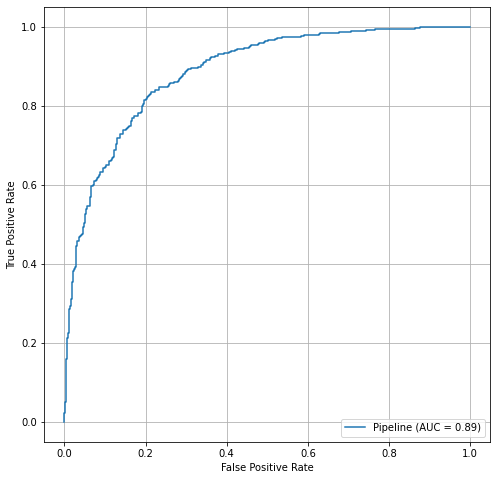

In [60]:
fg, ax = plt.subplots(1, 1, figsize=(8,8))
plot_roc_curve(cb_pipeline, test_df[['text']], test_label, ax=ax)
plt.grid()